In [2]:
import numpy as np
import pandas as pd
import json

In [3]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [4]:
SYMBOLS = ['BANANAS','PEARLS','COCONUTS','PINA_COLADAS']
LOG_DIR = 'round2_logs/'

In [5]:
p = 'PEARLS'
b = 'BANANAS'

# DATA LOADING

In [13]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)
    for i in [4, 5]:
        for col in ['bid','ask']:
            md[f'{col}_{i}'] = np.nan
            md[f'{col}_sz_{i}'] = np.nan

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files,hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['buyer', 'seller'], inplace=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [682]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,6):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size


def quote_weighted_px_square(quote, levels=5):
    notional, size = 0, 0
    for x in ['bid','ask']:
        notional += np.square(quote[f'{x}_sz'])*quote[x]
        size += np.square(quote[f'{x}_sz'])
   
        for i in range(2, min(quote[f'{x}_levels'], levels)+1):
            notional += quote[f'{x}_{i}']*np.square(quote[f'{x}_sz_{i}'])
            size += np.square(quote[f'{x}_sz_{i}'])
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [676]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 2, 3, 4, 5, 10, 25, 50]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in MOVING_WINDOW_TIMES:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md['vwap']
    md['fair_v3'] = md.apply(quote_weighted_px_square, axis=1)
    
    for t in HIST_PX_TIMES:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
        md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'bid_move_{t}'].fillna(0, inplace=True)
        md[f'ask_move_{t}'].fillna(0, inplace=True)
        
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    md = md.copy()
    
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
    if 'buy_vol' in md.columns:
        for t in MOVING_WINDOW_TIMES:
            md[f'buy_vol_{t}'] = md['buy_vol'].rolling(t, min_periods=0).sum()
            md[f'sell_vol_{t}'] = md['sell_vol'].rolling(t, min_periods=0).sum()
        md['volume_imb'] = md.buy_vol-md.sell_vol # Positive implies people are preparing for quote to move in
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.bid.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.ask.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].sum(axis=1)
    md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3','bid_sz_4','bid_sz_5']].max(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].sum(axis=1)
    md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3','ask_sz_4','ask_sz_5']].max(axis=1)
    
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
            
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

In [10]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 'px_move_10': ['mean','std'], 'px_move_50': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)

## Load

In [683]:
data_dir = 'hist_data/island-data-bottle-round-2/'
hist_days = [-1, 0, 1]
quote_files = [f'{data_dir}prices_round_2_day_{i}.csv' for i in hist_days]
trade_files = [f'{data_dir}trades_round_2_day_{i}_nn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, hist_days)
for sym in SYMBOLS:
    hist_quotes[sym] = quote_preprocess(hist_quotes[sym])

In [678]:
hist_data_summary(hist_quotes, hist_trades)

BANANAS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,5.24,4882.11,-0.04,-0.21,0.81,0.29,17.59,18.02,1.41,1.4,23.23,22.47,24.59,24.38
std,1.89,40.41,2.02,3.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,24184.00,8599.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PEARLS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,6.77,9999.99,-0.00,0.00,0.51,0.24,8.21,8.19,1.92,1.92,19.71,19.68,23.08,23.07
std,2.47,1.50,2.11,2.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,15225.00,7284.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


COCONUTS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.47,8008.65,-0.02,-0.12,0.86,0.04,154.42,155.0,1.24,1.25,135.36,130.94,130.07,124.89
std,0.61,67.86,2.59,5.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,25731.00,1078.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PINA_COLADAS


,spread,mid_price,px_move_10,px_move_50,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.65,15016.37,-0.05,-0.26,0.29,0.03,71.16,71.27,1.35,1.35,64.9,64.4,62.44,62.7
std,0.59,109.60,6.71,15.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,NaN,8572.00,854.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TRADING LOG LOADING

In [1377]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    # empty_regex = re.compile(r"(\d+) \$")
    # orders_depth_regex = re.compile(r"(\d+) ORDER_DEPTHS (\{.*\})")
    # market_trades_regex = re.compile(r"(\d+) MARKET_TRADES (\{.*\})")
    # own_trades_regex = re.compile(r"(\d+) OWN_TRADES (\{.*\})")
    # position_regex = re.compile(r"(\d+) POSITION (\{.*\})")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            # match = empty_regex.match(l)
            # if match:
                # trading_states.append(match.group(1))
    # print(trading_states)
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    for col in ['fill_qty','active_qty','passive_qty']:
        orders[col].fillna(0, inplace=True)
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby('symbol')[col].transform(pd.Series.cumsum)
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

In [64]:
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    plt.tight_layout()
    
    return

def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    plt.tight_layout()
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')

## Load

BANANAS: PnL=1798.0 | Trades=268.0 | MarketVol=310 | Volume Filled=852.0 | POV=0.73 | Shares/Step=0.859 | PnL/Share=2.11
PEARLS: PnL=1555.0 | Trades=268.0 | MarketVol=191 | Volume Filled=698.0 | POV=0.79 | Shares/Step=0.704 | PnL/Share=2.228
COCONUTS: PnL=-2893.0 | Trades=44.0 | MarketVol=1424 | Volume Filled=750.0 | POV=0.34 | Shares/Step=0.756 | PnL/Share=-3.857
PINA_COLADAS: PnL=2524.0 | Trades=44.0 | MarketVol=488 | Volume Filled=386.0 | POV=0.44 | Shares/Step=0.389 | PnL/Share=6.539
Total PnL=2984.0


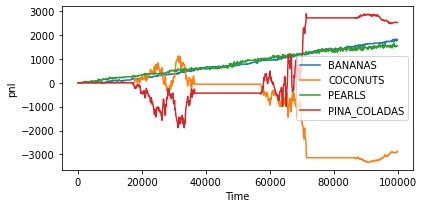

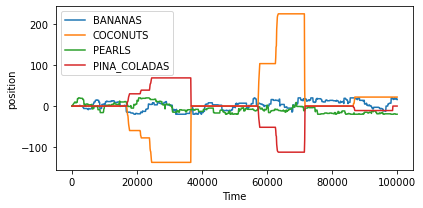

In [1401]:
file_name = 'f4a98a64-1f62-4529-89e1-7c189ac51d62'
file_name = '73961af3-b38a-459b-a5fa-d6bec4efde72'
file_name = 'e6074822-e820-44f6-9173-e2e828968a06'

file_name = "9f47348f-1a5d-4adf-853e-9f5ed251bde1"
file_name = "ccaeeb71-a6bf-4142-a2d8-7562431bf459"
file_name = "ba732f27-5392-4475-93f2-0970c1a89240"

# file_name = "f6649c72-1af8-4010-9eb8-0f058377e593"
# file_name = "951031dd-cae5-4f04-ab95-daf8bc980ec2"
# file_name = "c811040c-9d8a-4e99-85d3-16c84dab8d17"
# file_name = "3807a479-6de3-4c39-bc0c-07fc1486aa9f"
# file_name = "65ebb078-6db4-4d02-a5bb-779f48418e57"

file_name = "a2232618-bf70-469d-ad19-2fc17cbac891"

log_file = LOG_DIR + file_name + '.log'
dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

## Backtest

BANANAS: PnL=15676.5 | Trades=2258.0 | MarketVol=8511 | Volume Filled=9003.0 | POV=0.51 | Shares/Step=0.9 | PnL/Share=1.741
PEARLS: PnL=6256.0 | Trades=1629.0 | MarketVol=5176 | Volume Filled=4037.0 | POV=0.44 | Shares/Step=0.404 | PnL/Share=1.55
COCONUTS: PnL=-13463.0 | Trades=142.0 | MarketVol=8221 | Volume Filled=7082.0 | POV=0.46 | Shares/Step=0.708 | PnL/Share=-1.901
PINA_COLADAS: PnL=9035.5 | Trades=147.0 | MarketVol=2860 | Volume Filled=3599.0 | POV=0.56 | Shares/Step=0.36 | PnL/Share=2.511
Total PnL=17505.0


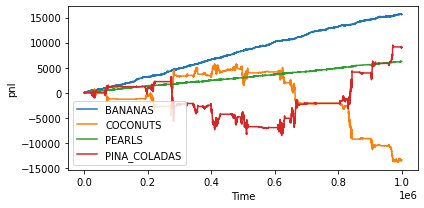

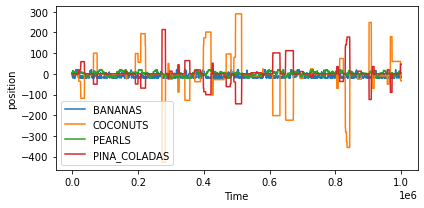

In [1349]:
log_file = "backtest_logs/backtest.log"
dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

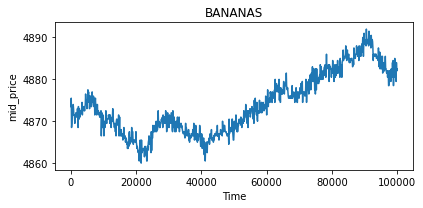

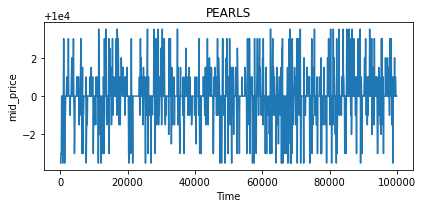

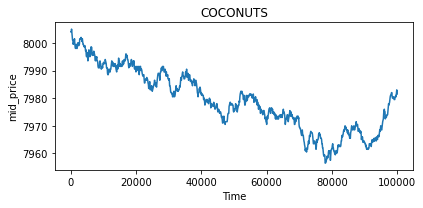

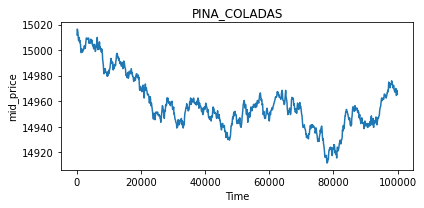

In [270]:
for sym in SYMBOLS:
    quote = dfs['quote'][sym]
    plot_col_sym(quote, sym, 'mid_price')

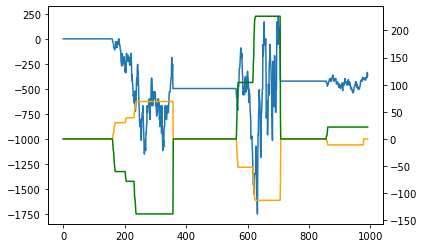

In [1402]:
pair_pnl = dfs['positions']['COCONUTS']['pnl'] + dfs['positions']['PINA_COLADAS']['pnl']

ax = pair_pnl.plot()
ax2 = ax.twinx()
ax2.plot(dfs['positions']['PINA_COLADAS']['position'], color='orange')
ax2.plot(dfs['positions']['COCONUTS']['position'], color='green')

<AxesSubplot:>

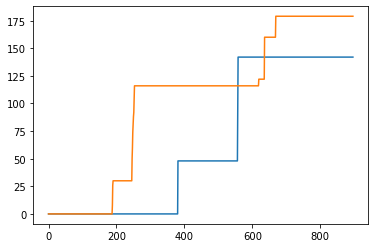

In [1382]:
dfs['positions']['COCONUTS']['total_buy_qty'].plot()
dfs['positions']['COCONUTS']['total_sell_qty'].plot()

# Trading Log Analytics

In [217]:
def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

algo_market_cols = ['symbol', 'timestamp', 'price_algo_buy', 'price_algo_sell','algo_spread']
def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market

def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

def get_orders_fills(market_trades, orders, quote):
    algo_market = get_algo_market(orders, quote)

    orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty']
    fills = orders.loc[orders.fill_qty > 0]
    fills = fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    order_analysis(fills)
    fills = fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

    missed_fills = orders[orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
    missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    missed_fills = missed_fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])
    
    return fills, missed_fills

In [1360]:
sym = 'PINA_COLADAS'
sym = 'COCONUTS'

market_trades = dfs['market_trades'][sym]
orders = dfs['orders'][sym]
quote = dfs['order_depths'][sym].copy()
fills, missed_fills = get_orders_fills(market_trades, orders, quote)

In [1361]:
pd.concat([orders['note'].value_counts().rename('orders'), fills['note'].value_counts().rename('fills')],axis=1)

,orders,fills
Pair_exit_passive,84,1
Pair_enter_long,11,11
Pair_exit_active,6,4
Pair_enter_short,2,2


In [1362]:
fills.groupby(['side','note'])[['pnl_1','pnl_5','pnl_10','pnl_25','pnl_50','fill_qty']].sum()

pnl_1  pnl_5  pnl_10  pnl_25  pnl_50  fill_qty
side note                                                             
-1   Pair_enter_long   -129.0 -155.0  -365.0  -505.0   326.0     116.0
     Pair_exit_active   -84.5  -18.5   -99.0   -44.0    26.0      63.0
 1   Pair_enter_short  -162.0   42.0  -178.0    -5.0  -141.0      94.0
     Pair_exit_active  -114.0 -133.0  -133.0   114.0   247.0      38.0
     Pair_exit_passive  -20.0  -25.0   -25.0    40.0    75.0      10.0

In [616]:
fills['pnl_1'].sum()

-37.5

In [224]:
quote.loc[quote.timestamp == 3800][['fair_v1','bid_2','bid_sz_2','ask_2','ask_sz_2', 'ask_3','ask_sz_3']]

,fair_v1,bid_2,bid_sz_2,ask_2,ask_sz_2,ask_3,ask_sz_3
37,15006.414508,NaN,NaN,15008.0,80.0,NaN,NaN


In [667]:
fills[['note','price','quantity','side','timestamp','bid','ask','bid_sz','ask_sz','fair_v1','fill_qty', 'pnl_10']].head()

,note,price,quantity,side,timestamp,bid,ask,bid_sz,ask_sz,fair_v1,fill_qty,pnl_10
0,P0,15008,20,1,1000,15007.0,15008.0,38.0,38.0,15008.000000,20.0,-160.0
1,X_0,15009,22,-1,3200,15009.0,15010.0,22.0,39.0,15009.000000,22.0,77.0
2,X_0,15006,33,1,3800,15005.0,15006.0,80.0,33.0,15006.414508,33.0,-33.0
3,P0,15006,20,1,3800,15005.0,15006.0,80.0,33.0,15006.414508,33.0,-33.0
4,P0,14998,20,-1,8000,14996.0,14999.0,97.0,97.0,14997.500000,2.0,29.0


In [240]:
orders.loc[orders.timestamp >= 500][['note','price','quantity','side','timestamp','bid','ask','bid_sz','ask_sz','fill_qty']].head()

,note,price,quantity,side,timestamp,bid,ask,bid_sz,ask_sz,fill_qty
10,P0,15009,10,1,500,15008.0,15011.0,107.0,37.0,0.0
11,P0,15010,10,-1,500,15008.0,15011.0,107.0,37.0,0.0
12,P0,15007,10,1,600,15006.0,15009.0,90.0,90.0,0.0
13,P0,15008,10,-1,600,15006.0,15009.0,90.0,90.0,0.0
14,P0,15008,10,1,700,15007.0,15010.0,106.0,106.0,0.0


In [237]:
fills[['note','price','quantity','side','timestamp','bid','ask','bid_sz','ask_sz','fair_v1','fill_qty', 'pnl_10']].head()

,note,price,quantity,side,timestamp,bid,ask,bid_sz,ask_sz,fair_v1,fill_qty,pnl_10
0,P0,15008,10,1,1000,15007.0,15008.0,38.0,38.0,15008.000000,10.0,-80.0
1,P0,15009,10,-1,3200,15009.0,15010.0,22.0,39.0,15009.000000,10.0,35.0
2,X_0,15006,33,1,3800,15005.0,15006.0,80.0,33.0,15006.414508,33.0,-33.0
3,P0,15006,10,1,3800,15005.0,15006.0,80.0,33.0,15006.414508,33.0,-33.0
4,P0,14998,10,-1,8000,14996.0,14999.0,97.0,97.0,14997.500000,2.0,29.0


In [700]:
dfs['own_trades'][sym].head()

,price,quantity,symbol,timestamp,side,bid,ask,bid_sz,ask_sz,mid_price,active,active_qty,passive_qty
0,15008.0,20,PINA_COLADAS,1000,1,15007.0,15008.0,38,38,15007.5,True,20,0
1,15009.0,22,PINA_COLADAS,3200,-1,15009.0,15010.0,22,39,15009.5,True,22,0
2,15006.0,33,PINA_COLADAS,3800,1,15005.0,15006.0,80,33,15005.5,True,33,0
3,14998.0,2,PINA_COLADAS,8000,-1,14996.0,14999.0,97,97,14997.5,False,0,2
4,14983.0,20,PINA_COLADAS,8800,1,14982.0,14983.0,80,20,14982.5,True,20,0


In [870]:
orders

,note,price,quantity,side,symbol,timestamp,bid,ask,bid_sz,ask_sz,mid_price,fill_qty,active_qty,passive_qty,fill_pct
0,PP_0,15018,10,-1,PINA_COLADAS,200,15015.0,15018.0,23.0,74.0,15016.5,0.0,0.0,0.0,0.0
1,PP_0,15011,10,-1,PINA_COLADAS,500,15008.0,15011.0,107.0,37.0,15009.5,0.0,0.0,0.0,0.0
2,PP_0,15011,10,-1,PINA_COLADAS,800,15009.0,15011.0,31.0,31.0,15010.0,0.0,0.0,0.0,0.0
3,PP_0,15005,10,1,PINA_COLADAS,900,15005.0,15008.0,85.0,25.0,15006.5,0.0,0.0,0.0,0.0
4,PP_0,14998,10,1,PINA_COLADAS,1900,14998.0,15000.0,37.0,37.0,14999.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,PP_0,14972,10,1,PINA_COLADAS,97900,14972.0,14975.0,91.0,25.0,14973.5,0.0,0.0,0.0,0.0
166,PP_0,14977,10,-1,PINA_COLADAS,98100,14975.0,14977.0,21.0,90.0,14976.0,0.0,0.0,0.0,0.0
167,PP_0,14968,10,-1,PINA_COLADAS,99200,14966.0,14968.0,24.0,94.0,14967.0,0.0,0.0,0.0,0.0
168,PP_0,14971,10,-1,PINA_COLADAS,99500,14969.0,14970.0,15.0,85.0,14969.5,0.0,0.0,0.0,0.0


In [598]:
orders['note'].value_counts()

P0     1420
X_0      21
Name: note, dtype: int64

In [599]:
fills['side'].value_counts()

 1    33
-1    13
Name: side, dtype: int64

In [600]:
fills['note'].value_counts()

P0     25
X_0    21
Name: note, dtype: int64

In [602]:
fills.groupby('note')['toxicity_10'].sum()

note
P0     1.0
X_0   -6.0
Name: toxicity_10, dtype: float64

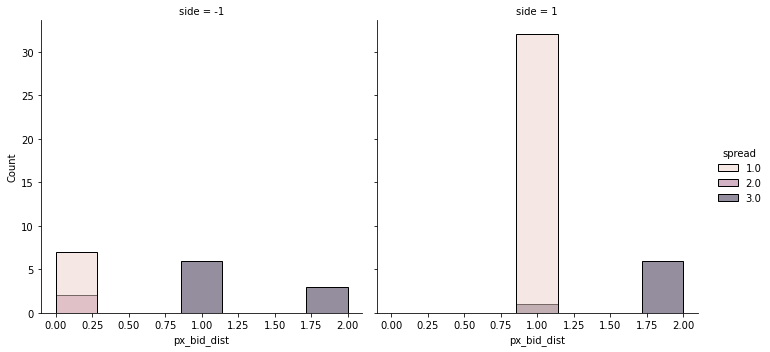

In [745]:
sns.displot(x='px_bid_dist', data=fills, col='side', hue='spread')

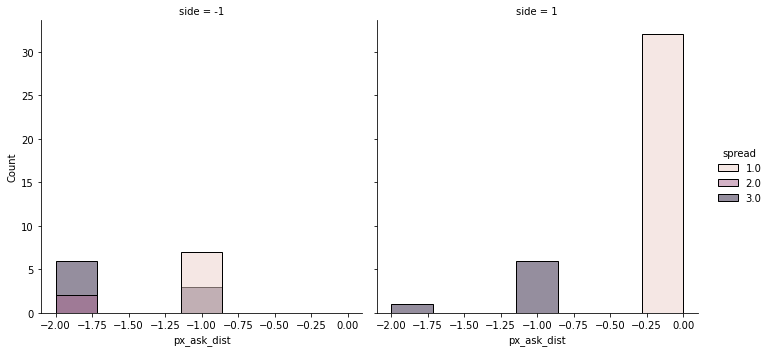

In [746]:
sns.displot(x='px_ask_dist', data=fills, col='side', hue='spread')

In [260]:
missed_fills['note'].value_counts()

P3     70
P0     32
P2     29
P4     27
X_0    26
P1     18
Name: note, dtype: int64

In [262]:
total_fills = fills.groupby(['side'])['fill_qty'].sum()
fill_win = fills.groupby(['side','note'])['fill_qty'].sum()
fill_win = fill_win
fill_win.unstack()

note,P0,P1,P2,P3,P4,X_0
side,,,,,,
-1,12.0,9.0,84.0,49.0,27.0,179.0
1,11.0,10.0,21.0,56.0,38.0,204.0


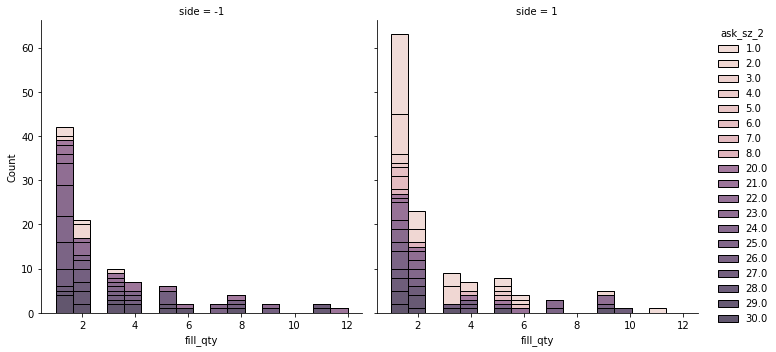

In [204]:
sns.displot(x='fill_qty', data=fills, hue='ask_sz_2', multiple='stack', col='side')

In [148]:
missed_vol = missed_fills.groupby(['side_algo'])['quantity_mkt'].sum()
missed_vol_type = missed_fills.groupby(['side_algo','note'])['quantity_mkt'].sum()
missed_vol_type.unstack()

note,P0,P1,P2,P3,P4,X_0
side_algo,,,,,,
-1,2,6,44,76,24,28
1,27,30,15,72,34,12


# Historical Quote Analysis

BANANAS
PEARLS
COCONUTS
PINA_COLADAS


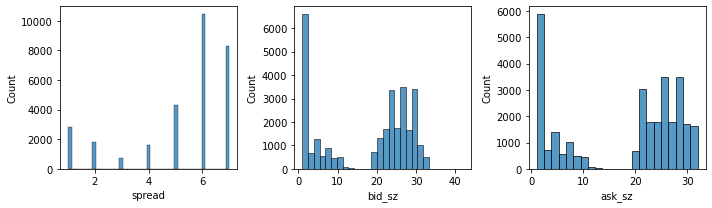

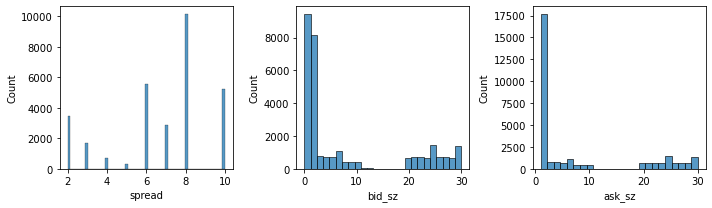

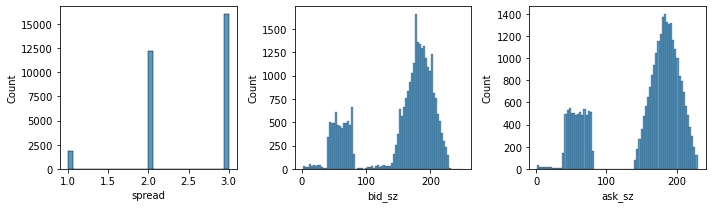

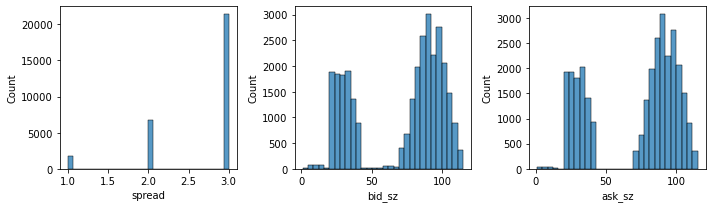

In [141]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['spread','bid_sz','ask_sz']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

BANANAS
PEARLS
COCONUTS
PINA_COLADAS


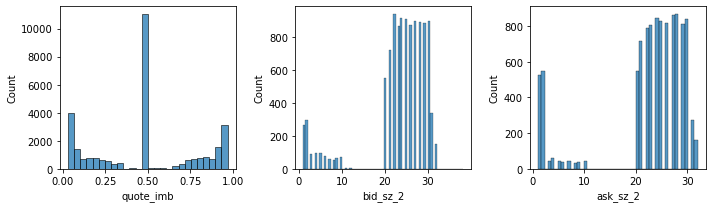

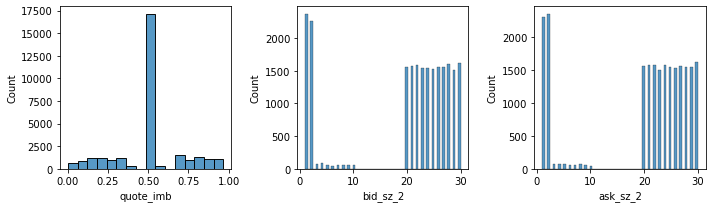

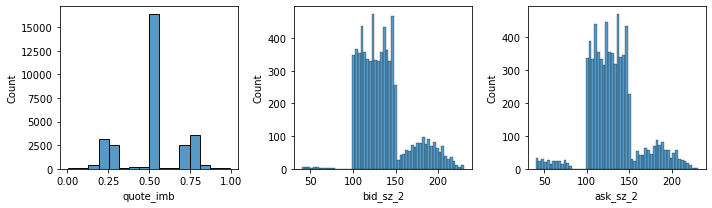

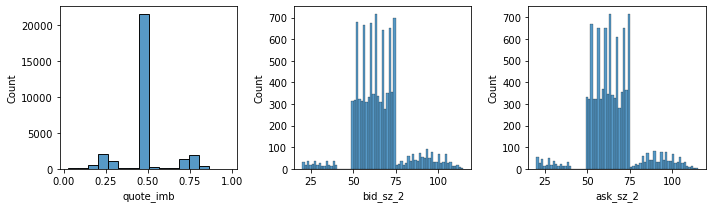

In [171]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['quote_imb','bid_sz_2','ask_sz_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

BANANAS
PEARLS
COCONUTS
PINA_COLADAS


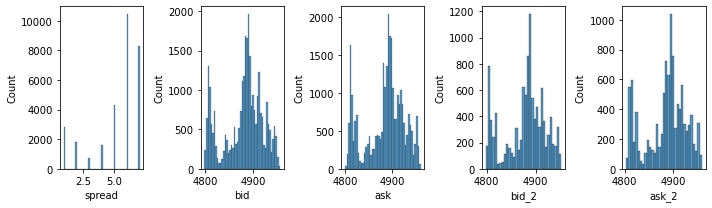

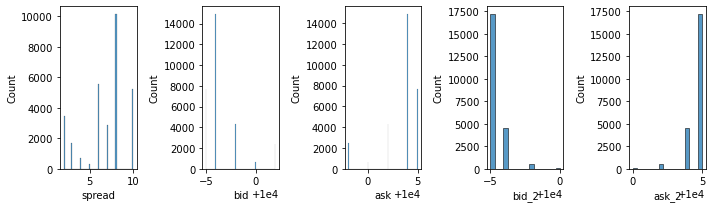

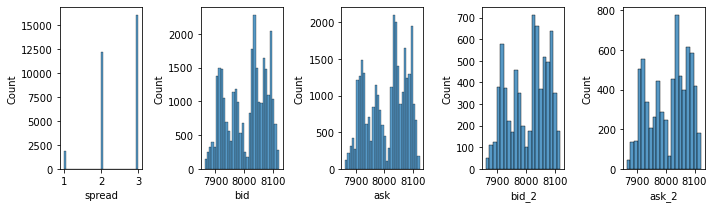

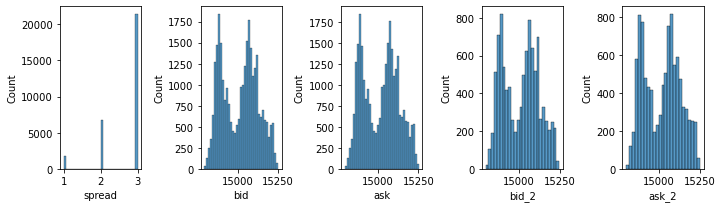

In [142]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['spread','bid','ask', 'bid_2','ask_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

BANANAS
PEARLS
COCONUTS
PINA_COLADAS


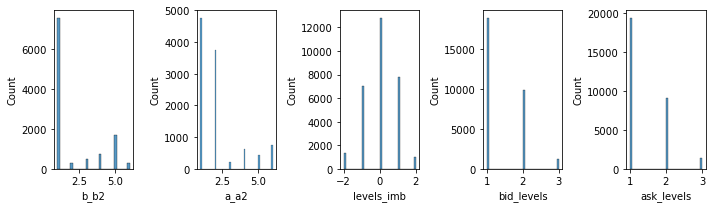

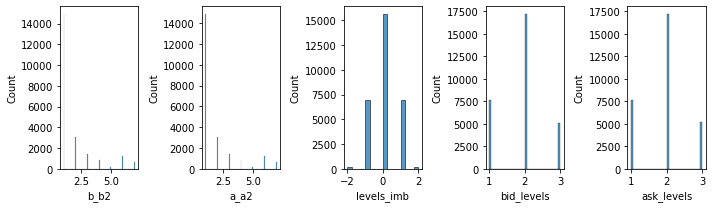

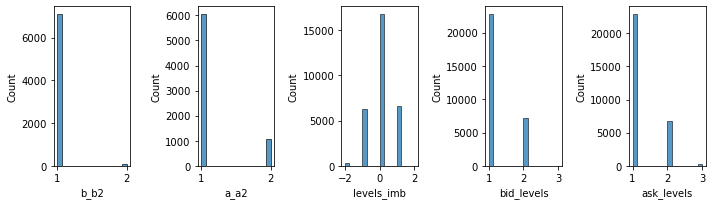

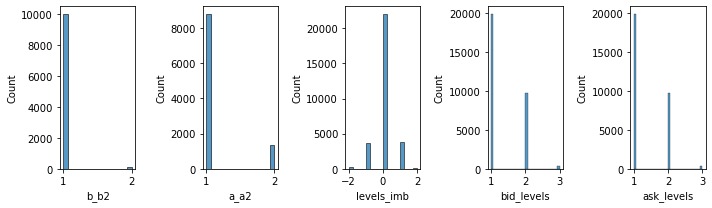

In [143]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    quote['b_b2'] = quote['bid'] - quote['bid_2']
    quote['a_a2'] = quote['ask_2'] - quote['ask']
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['b_b2','a_a2','levels_imb', 'bid_levels', 'ask_levels']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

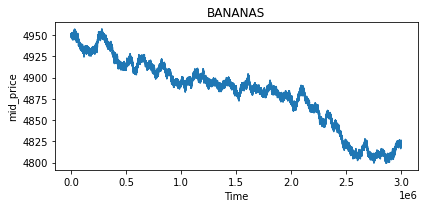

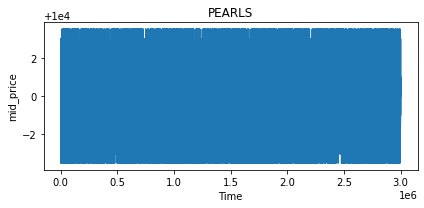

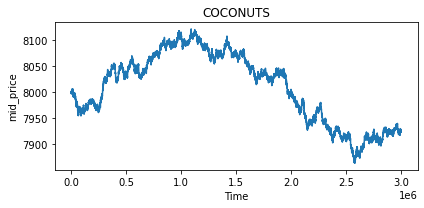

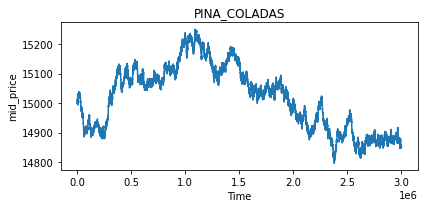

In [144]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    plot_col_sym(quote, sym, 'mid_price')

## Random Analysis

In [146]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'

quote1 = hist_quotes[sym1].drop(columns='day')
quote2 = hist_quotes[sym2].drop(columns='day').copy()

In [213]:
quote1.loc[quote1.quote_imb < 0.1][['fpx_move_1', 'spread']].describe()

,fpx_move_1,spread
count,187.000000,187.000000
mean,-0.417112,1.550802
std,0.781043,0.498748
min,-1.000000,1.000000
25%,-1.000000,1.000000
50%,-1.000000,2.000000
75%,0.000000,2.000000
max,1.000000,2.000000


In [214]:
quote2.loc[quote1.quote_imb < 0.1][['fpx_move_1', 'spread']].describe()

,fpx_move_1,spread
count,187.000000,187.000000
mean,0.026738,2.647059
std,0.924186,0.589814
min,-1.000000,1.000000
25%,-1.000000,2.000000
50%,0.000000,3.000000
75%,1.000000,3.000000
max,1.000000,3.000000


# Historical Trade Analysis

In [368]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades['quantity'].describe().rename(sym))
pd.concat(summ,axis=1)

,BANANAS,PEARLS,COCONUTS,PINA_COLADAS
count,8599.00000,7284.000000,1078.000000,854.000000
mean,2.81242,2.090198,23.869202,10.037471
std,3.70813,1.993252,19.859314,8.963179
min,0.00000,0.000000,1.000000,1.000000
25%,1.00000,1.000000,8.000000,4.000000
50%,1.00000,1.000000,14.000000,6.000000
75%,2.00000,2.000000,43.000000,13.000000
max,20.00000,12.000000,79.000000,39.000000


In [662]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades.groupby('timestamp')['quantity'].sum().describe().rename(sym))
pd.concat(summ,axis=1)

,BANANAS,PEARLS,COCONUTS,PINA_COLADAS
count,7542.000000,6216.000000,986.000000,807.000000
mean,3.206577,2.449324,26.096349,10.622057
std,4.209759,2.480756,22.481800,9.887564
min,1.000000,1.000000,5.000000,2.000000
25%,1.000000,1.000000,8.000000,4.000000
50%,1.000000,1.000000,14.000000,6.000000
75%,3.000000,3.000000,46.000000,14.000000
max,31.000000,20.000000,80.000000,40.000000


BANANAS
PEARLS
COCONUTS
PINA_COLADAS


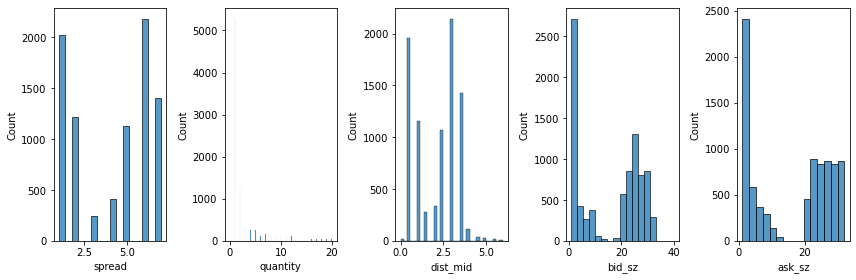

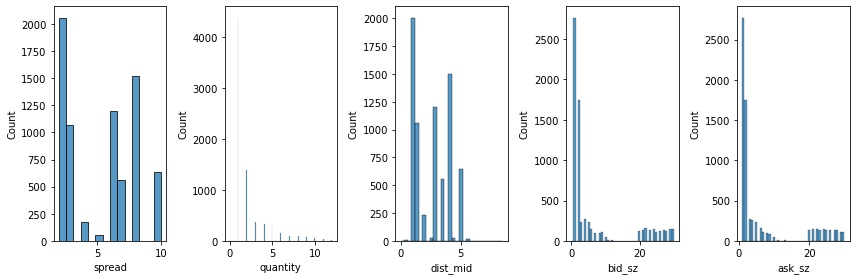

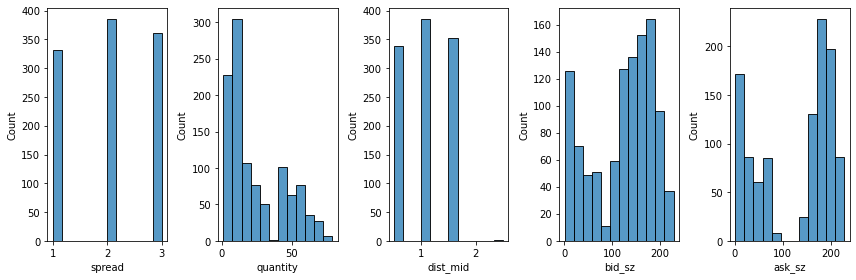

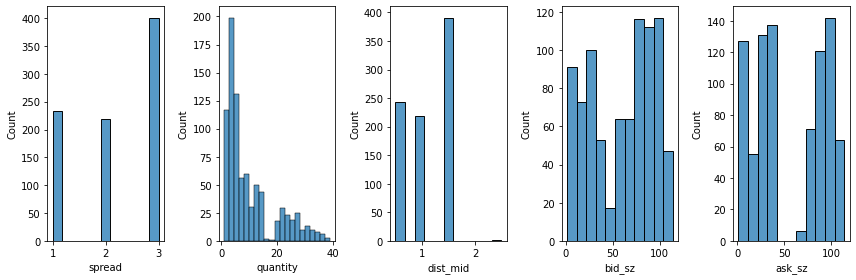

In [369]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['spread'] = trades['ask']-trades['bid']
    trades['dist_mid'] = np.abs(trades['mid_price']-trades['price'])
    
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(12,4))
    for i, col in enumerate(['spread','quantity', 'dist_mid', 'bid_sz','ask_sz']):
        sns.histplot(x=col, data=trades, ax=ax[i])
    plt.tight_layout()

BANANAS
PEARLS
COCONUTS
PINA_COLADAS


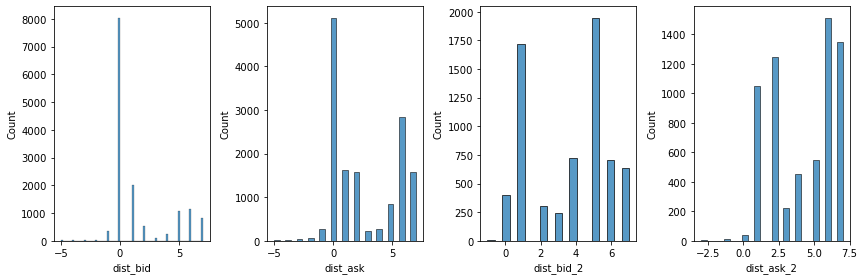

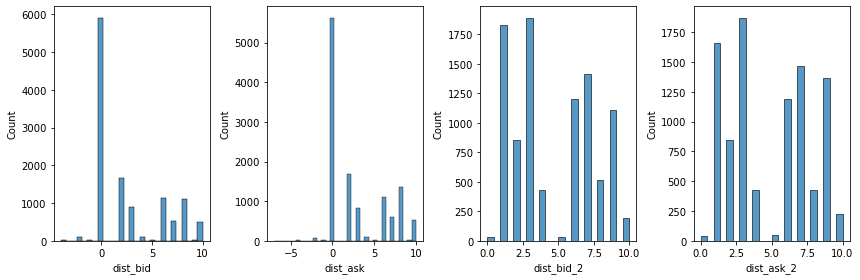

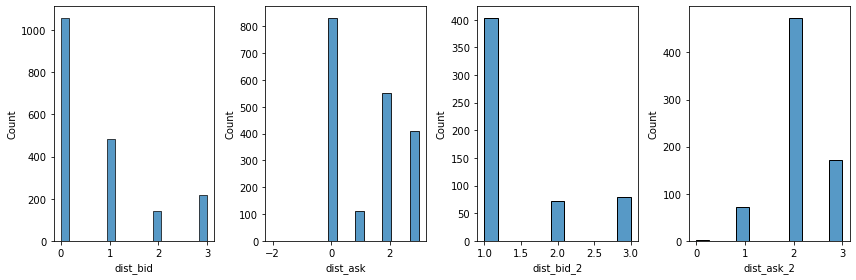

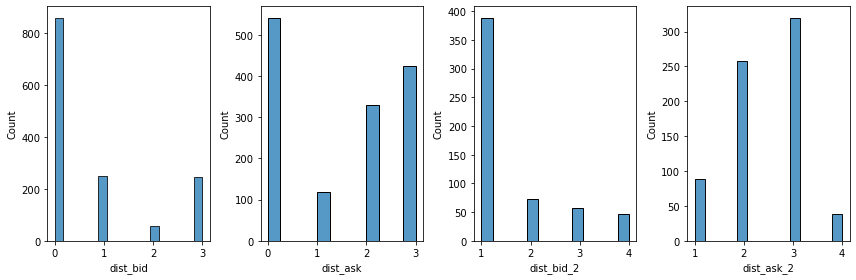

In [297]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['dist_bid'] = trades['price']-trades['bid']
    trades['dist_ask'] = trades['ask']-trades['price']
    
    trades['dist_bid_2'] = trades['price']-trades['bid_2']
    trades['dist_ask_2'] = trades['ask_2']-trades['price']
    
    print(sym)
    f, ax = plt.subplots(1, 4, figsize=(12,4))
    for i, col in enumerate(['dist_bid','dist_ask','dist_bid_2','dist_ask_2']):
        sns.histplot(x=col, data=trades, ax=ax[i])
    plt.tight_layout()

# Symbol Specific Correlation Analysis

In [469]:
mid_labels = []
bid_labels = []
ask_labels = []
px_delta_cols = []

for t in FUTURE_TIMES:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [684]:
for sym in SYMBOLS:
    sub_data = hist_quotes[sym].copy()
    # sub_data = sub_data.loc[np.abs(sub_data.dist_fair_v1) > 0.5]
    print("{} {} {} {:.2f}%".format(sym, len(hist_quotes[sym].copy()), len(sub_data), 100*len(sub_data)/len(quote)))
    corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'fair_v1_move_1', 'dist_fair_v3'] + mid_labels].corr()
    display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

BANANAS 30000 30000 3003.00%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,dist_fair_v3,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50
quote_imb,1.000,-0.905,0.735,0.191,0.677,0.399,0.379,0.364,0.357,0.342,0.302,0.232,0.188
levels_imb,-0.905,1.000,-0.821,-0.194,-0.757,-0.458,-0.434,-0.416,-0.406,-0.389,-0.345,-0.265,-0.213
dist_fair_v1,0.735,-0.821,1.000,0.068,0.993,0.525,0.509,0.494,0.479,0.466,0.427,0.344,0.280
fair_v1_move_1,0.191,-0.194,0.068,1.000,0.042,-0.008,-0.009,-0.012,-0.005,-0.007,-0.019,-0.020,-0.018
dist_fair_v3,0.677,-0.757,0.993,0.042,1.000,0.517,0.503,0.489,0.474,0.461,0.426,0.345,0.281
fpx_move_1,0.399,-0.458,0.525,-0.008,0.517,1.000,0.419,0.393,0.367,0.363,0.311,0.236,0.190
fpx_move_2,0.379,-0.434,0.509,-0.009,0.503,0.419,1.000,0.457,0.428,0.406,0.346,0.270,0.212
fpx_move_3,0.364,-0.416,0.494,-0.012,0.489,0.393,0.457,1.000,0.480,0.452,0.383,0.283,0.228
fpx_move_4,0.357,-0.406,0.479,-0.005,0.474,0.367,0.428,0.480,1.000,0.498,0.410,0.303,0.244
fpx_move_5,0.342,-0.389,0.466,-0.007,0.461,0.363,0.406,0.452,0.498,1.000,0.444,0.330,0.251


PEARLS 30000 30000 3003.00%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,dist_fair_v3,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50
quote_imb,1.000,-0.084,0.256,0.001,0.270,0.090,0.100,0.092,0.097,0.102,0.100,0.088,0.096
levels_imb,-0.084,1.000,-0.881,0.095,-0.816,-0.622,-0.623,-0.624,-0.623,-0.615,-0.615,-0.623,-0.621
dist_fair_v1,0.256,-0.881,1.000,0.070,0.989,0.582,0.584,0.587,0.584,0.581,0.580,0.583,0.581
fair_v1_move_1,0.001,0.095,0.070,1.000,0.153,-0.093,-0.094,-0.093,-0.089,-0.090,-0.081,-0.088,-0.094
dist_fair_v3,0.270,-0.816,0.989,0.153,1.000,0.541,0.543,0.546,0.544,0.540,0.540,0.543,0.540
fpx_move_1,0.090,-0.622,0.582,-0.093,0.541,1.000,0.415,0.414,0.407,0.406,0.408,0.404,0.412
fpx_move_2,0.100,-0.623,0.584,-0.094,0.543,0.415,1.000,0.412,0.410,0.405,0.406,0.410,0.409
fpx_move_3,0.092,-0.624,0.587,-0.093,0.546,0.414,0.412,1.000,0.408,0.406,0.405,0.411,0.411
fpx_move_4,0.097,-0.623,0.584,-0.089,0.544,0.407,0.410,0.408,1.000,0.407,0.407,0.395,0.409
fpx_move_5,0.102,-0.615,0.581,-0.090,0.540,0.406,0.405,0.406,0.407,1.000,0.399,0.409,0.402


COCONUTS 30000 30000 3003.00%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,dist_fair_v3,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50
quote_imb,1.000,-0.970,0.906,0.152,0.468,0.146,0.106,0.092,0.080,0.071,0.052,0.024,0.015
levels_imb,-0.970,1.000,-0.911,-0.156,-0.445,-0.144,-0.106,-0.092,-0.079,-0.071,-0.052,-0.024,-0.016
dist_fair_v1,0.906,-0.911,1.000,0.110,0.768,0.194,0.146,0.126,0.109,0.100,0.072,0.033,0.023
fair_v1_move_1,0.152,-0.156,0.110,1.000,-0.002,-0.018,-0.008,0.007,0.005,0.004,0.008,0.003,-0.006
dist_fair_v3,0.468,-0.445,0.768,-0.002,1.000,0.201,0.155,0.131,0.115,0.109,0.075,0.035,0.025
fpx_move_1,0.146,-0.144,0.194,-0.018,0.201,1.000,0.560,0.449,0.383,0.342,0.236,0.142,0.096
fpx_move_2,0.106,-0.106,0.146,-0.008,0.155,0.560,1.000,0.659,0.553,0.487,0.335,0.200,0.136
fpx_move_3,0.092,-0.092,0.126,0.007,0.131,0.449,0.659,1.000,0.717,0.618,0.409,0.241,0.163
fpx_move_4,0.080,-0.079,0.109,0.005,0.115,0.383,0.553,0.717,1.000,0.754,0.479,0.278,0.188
fpx_move_5,0.071,-0.071,0.100,0.004,0.109,0.342,0.487,0.618,0.754,1.000,0.545,0.313,0.208


PINA_COLADAS 30000 30000 3003.00%


,quote_imb,levels_imb,dist_fair_v1,fair_v1_move_1,dist_fair_v3,fpx_move_1,fpx_move_2,fpx_move_3,fpx_move_4,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50
quote_imb,1.000,-0.939,0.840,-0.011,0.320,0.090,0.070,0.053,0.044,0.044,0.026,0.016,0.007
levels_imb,-0.939,1.000,-0.903,0.008,-0.379,-0.098,-0.077,-0.058,-0.048,-0.047,-0.031,-0.017,-0.011
dist_fair_v1,0.840,-0.903,1.000,-0.008,0.730,0.108,0.083,0.063,0.051,0.050,0.031,0.016,0.011
fair_v1_move_1,-0.011,0.008,-0.008,1.000,-0.001,-0.010,-0.005,-0.006,-0.007,0.001,0.005,0.005,-0.001
dist_fair_v3,0.320,-0.379,0.730,-0.001,1.000,0.077,0.056,0.045,0.035,0.033,0.017,0.005,0.004
fpx_move_1,0.090,-0.098,0.108,-0.010,0.077,1.000,0.541,0.421,0.361,0.319,0.215,0.140,0.095
fpx_move_2,0.070,-0.077,0.083,-0.005,0.056,0.541,1.000,0.646,0.527,0.456,0.309,0.194,0.123
fpx_move_3,0.053,-0.058,0.063,-0.006,0.045,0.421,0.646,1.000,0.694,0.589,0.386,0.244,0.153
fpx_move_4,0.044,-0.048,0.051,-0.007,0.035,0.361,0.527,0.694,1.000,0.734,0.458,0.287,0.178
fpx_move_5,0.044,-0.047,0.050,0.001,0.033,0.319,0.456,0.589,0.734,1.000,0.524,0.325,0.204


In [317]:
for sym in SYMBOLS[2:]:
    sub_data = hist_quotes[sym].copy()
    # sub_data = sub_data.loc[np.abs(sub_data.dist_fair_v1) > 0.5]
    print("{} {} {} {:.2f}%".format(sym, len(hist_quotes[sym].copy()), len(sub_data), 100*len(sub_data)/len(quote)))
    corr = sub_data[['buy_vol_25', 'sell_vol_25','buy_vol_50', 'sell_vol_50'] + mid_labels].corr()
    display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

COCONUTS 30000 30000 100.00%


,buy_vol_25,sell_vol_25,buy_vol_50,sell_vol_50,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100
buy_vol_25,1.000,-0.049,0.704,-0.023,-0.006,-0.023,-0.019,0.006,-0.008,0.009
sell_vol_25,-0.049,1.000,-0.056,0.720,0.011,0.008,0.003,-0.020,0.010,0.009
buy_vol_50,0.704,-0.056,1.000,-0.055,-0.002,-0.009,-0.007,-0.007,-0.021,0.008
sell_vol_50,-0.023,0.720,-0.055,1.000,0.017,0.015,0.011,0.009,0.025,0.030
fpx_move_1,-0.006,0.011,-0.002,0.017,1.000,0.342,0.236,0.142,0.096,0.071
fpx_move_5,-0.023,0.008,-0.009,0.015,0.342,1.000,0.545,0.313,0.208,0.158
fpx_move_10,-0.019,0.003,-0.007,0.011,0.236,0.545,1.000,0.469,0.308,0.230
fpx_move_25,0.006,-0.020,-0.007,0.009,0.142,0.313,0.469,1.000,0.522,0.361
fpx_move_50,-0.008,0.010,-0.021,0.025,0.096,0.208,0.308,0.522,1.000,0.499
fpx_move_100,0.009,0.009,0.008,0.030,0.071,0.158,0.230,0.361,0.499,1.000


PINA_COLADAS 30000 30000 100.00%


,buy_vol_25,sell_vol_25,buy_vol_50,sell_vol_50,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_25,fpx_move_50,fpx_move_100
buy_vol_25,1.000,0.007,0.703,0.015,0.005,0.000,0.002,0.010,0.040,0.045
sell_vol_25,0.007,1.000,0.016,0.706,0.005,0.007,0.001,0.013,0.019,0.019
buy_vol_50,0.703,0.016,1.000,0.021,0.008,0.011,0.021,0.036,0.064,0.054
sell_vol_50,0.015,0.706,0.021,1.000,0.005,0.013,0.005,0.031,0.044,0.022
fpx_move_1,0.005,0.005,0.008,0.005,1.000,0.319,0.215,0.140,0.095,0.065
fpx_move_5,0.000,0.007,0.011,0.013,0.319,1.000,0.524,0.325,0.204,0.149
fpx_move_10,0.002,0.001,0.021,0.005,0.215,0.524,1.000,0.476,0.300,0.210
fpx_move_25,0.010,0.013,0.036,0.031,0.140,0.325,0.476,1.000,0.520,0.333
fpx_move_50,0.040,0.019,0.064,0.044,0.095,0.204,0.300,0.520,1.000,0.492
fpx_move_100,0.045,0.019,0.054,0.022,0.065,0.149,0.210,0.333,0.492,1.000


## LR

In [110]:
from sklearn.linear_model import LogisticRegression


In [888]:
for sym in ['PEARLS']:
    print(sym)
    data = hist_quotes[sym].copy()
    features = ['dist_fair_v1', 'dist_fair_v2']

    labels = mid_labels
    total_samples = len(data)
    train_samples = total_samples//2

    train_data = data.iloc[:train_samples][features+labels]
    X_train = train_data[features].values
    clfs = {}

    for t in FUTURE_TIMES:
        y_train = train_data[f'fpx_move_{t}'].values
        clfs[t] = LogisticRegression(random_state=0, penalty='none').fit(X_train, y_train)

    for t in FUTURE_TIMES:
        probs = clfs[t].predict_proba(X_train)
        train_data[f'predict_{t}'] = clfs[t].classes_[probs.argmax(axis=1)]
        train_data[f'predict_prob_{t}'] = probs.max(axis=1)
        train_data[f'correct_{t}'] = train_data[f'predict_{t}'] == train_data[f'fpx_move_{t}']
        print('{} {:.3}'.format(t, train_data[f'correct_{t}'].mean()))

PEARLS
1 0.389
2 0.393
3 0.394
4 0.395
5 0.395
10 0.392
25 0.394
50 0.391


In [891]:
train_data.loc[train_data['fpx_move_10']!=0][f'correct_{t}'].mean()

0.4449528167000286

# COCONUTS AND PINA COLADAS ANALYSIS

In [1017]:
from scipy import signal
import statsmodels.api as sm

In [1390]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'

quote1 = hist_quotes[sym1].drop(columns='day')
quote2 = hist_quotes[sym2].drop(columns='day').copy()
quote1 = dfs['quote'][sym1]
quote2 = dfs['quote'][sym2]

# trades1 = hist_trades[sym1].drop(columns='day')
# trades2 = hist_trades[sym2].drop(columns='day').copy()

In [1215]:
z_array = ratio.values
z_lag = np.roll(z_array,1)
z_lag[0] = 0
z_ret = z_array - z_lag
z_ret[0] = 0
#adds intercept terms to X variable for regression
z_lag2 = sm.add_constant(z_lag)
model = sm.OLS(z_ret,z_lag2)
res = model.fit()
halflife = -np.log(2)/res.params[1]
print(halflife)

675.3626938685871


In [1391]:
# ratio = (quote2['mid_price']-7000)/quote1['mid_price']-1
ratio = quote2['mid_price']/quote1['mid_price']-15/8
ratio *= 100

# signal = ratio.rolling(50,min_periods=0).mean()-ratio.rolling(100,min_periods=0).mean()
# signal = signal.rolling(50,min_periods=0).mean()
signal = (ratio.ewm(com=10,min_periods=0).mean()-ratio.ewm(com=50,min_periods=0).mean())
# signal = (ratio.ewm(com=10,min_periods=0).mean()-ratio.rolling(100,min_periods=0).mean())

signal_std = ratio.rolling(window=500, min_periods=0).std()

z_score = signal*20
# signal = np.clip(signal / signal.rolling(100,min_periods=0).std(), -3, 3)

<AxesSubplot:>

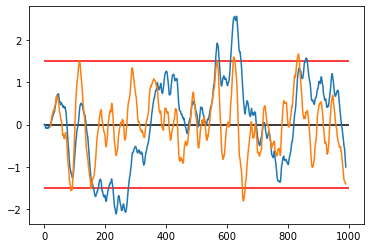

In [1396]:
xmax = 1000
ax = z_score.iloc[:xmax].plot()
ax.hlines(y=-1.5, xmin=0, xmax=xmax, color='red')
ax.hlines(y=0, xmin=0, xmax=xmax, color='black')
ax.hlines(y=1.5, xmin=0, xmax=xmax, color='red')

z_score.diff(20).iloc[:xmax].plot()

<AxesSubplot:>

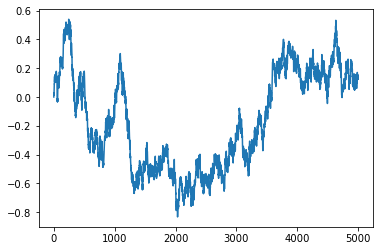

In [1337]:
ratio.iloc[:5000].plot()

<AxesSubplot:>

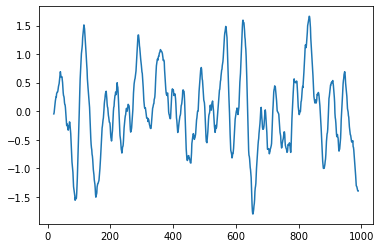

<AxesSubplot:>

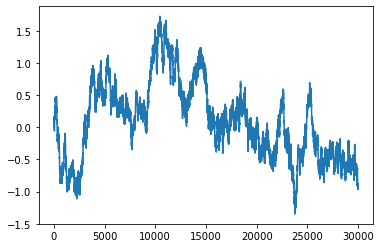

In [1072]:
ratio.plot()

<AxesSubplot:>

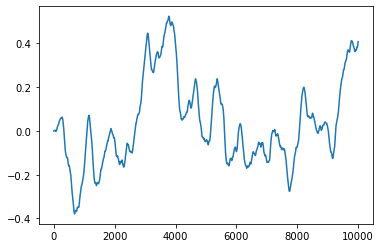

In [1058]:
signal.iloc[:10000].plot()

<AxesSubplot:>

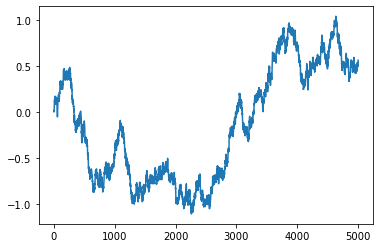

In [1059]:
ratio.iloc[:5000].plot()

In [688]:
# Is there a leader / lagger?
for col in ['mid_price','px_move_1', 'px_move_5', 'ask_sz','bid_sz', 'quote_imb', 'dist_fair_v3']:
    x = quote1[col].values
    y = quote2[col].values

    correlation = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    print(lag)

0
0
0
-12
8
13
-6834


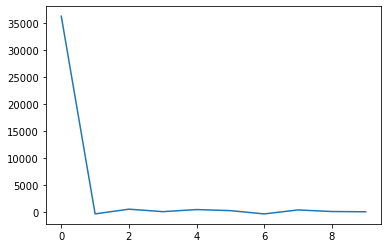

In [119]:
autocorr = np.correlate(quote2['fpx_1'].values,quote1['fpx_1'].values, mode='full')
autocorr = autocorr[autocorr.size//2:][:10]
f, ax = plt.subplots()
ax.plot(autocorr)

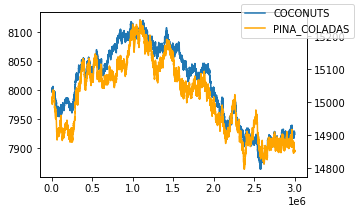

In [58]:
f, ax = plt.subplots(figsize=(5,3))
col = 'mid_price'
ax.plot('timestamp',col, data=quote1, label=sym1)
ax2 = ax.twinx()
ax2.plot('timestamp',col, data=quote2, label=sym2, color='orange')
f.legend()
plt.tight_layout()

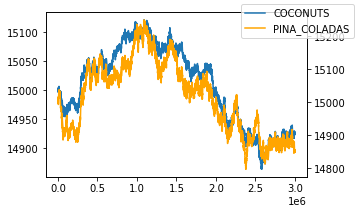

In [297]:
col = 'fair_price'
quote1['fair_price'] = quote1['mid_price']+7000
quote2['fair_price'] = quote2['mid_price']

f, ax = plt.subplots(figsize=(5,3))
ax.plot('timestamp',col, data=quote1, label=sym1)
ax2 = ax.twinx()
ax2.plot('timestamp',col, data=quote2, label=sym2, color='orange')
f.legend()
plt.tight_layout()

In [298]:
signal = quote1['fair_price'] - quote2['fair_price']
signal.describe()

count    30000.000000
mean        -7.711883
std         48.281503
min       -140.000000
25%        -38.000000
50%         -6.500000
75%         31.000000
max        106.500000
Name: fair_price, dtype: float64

In [77]:
signal = quote2['mid_price']-quote1['mid_price']*15/8

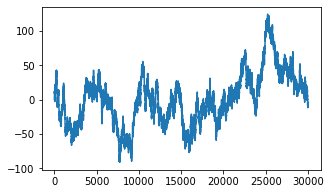

In [78]:
f, ax = plt.subplots(figsize=(5,3))
ax.plot(signal)
# ax.plot(signal.ewm(com=10).mean().diff(100))
# signal.ewm(com=10).mean().diff(100).describe()

In [689]:
pair_data = quote1.merge(quote2, on=['timestamp'], suffixes=('_'+sym1,'_'+sym2))

In [794]:
def coconut_fair_v3(quote):
    notional, size = 0, 0
    for x in ['bid','ask']:
        for i in range(2, quote[f'{x}_levels_COCONUTS']+1):
            notional += (quote[f'{x}_{i}_COCONUTS'])*quote[f'{x}_sz_{i}_COCONUTS']
            size += quote[f'{x}_sz_{i}_COCONUTS']
            
        if quote[f'{x}_sz_COCONUTS'] >= 40:
            notional += (quote[f'{x}_COCONUTS'])*quote[f'{x}_sz_COCONUTS']
            size += quote[f'{x}_sz_COCONUTS']
    return notional/size

def pina_colada_fair_v3(quote):
    notional, size = 0, 0
    
    for x in ['bid','ask']:
        for i in range(2, quote[f'{x}_levels_PINA_COLADAS']+1):
            notional += quote[f'{x}_{i}_PINA_COLADAS']*quote[f'{x}_sz_{i}_PINA_COLADAS']
            size += quote[f'{x}_sz_{i}_PINA_COLADAS']
        if quote[f'{x}_sz_PINA_COLADAS'] >= 20:
            notional += quote[f'{x}_PINA_COLADAS']*quote[f'{x}_sz_PINA_COLADAS']
            size += quote[f'{x}_sz_PINA_COLADAS']
        
    return notional/size

def pair_weighted_px(quote):
    notional, size = 0, 0
    for x in ['bid','ask']:
        for i in range(2, quote[f'{x}_levels_COCONUTS']+1):
            notional += (quote[f'{x}_{i}_COCONUTS']*15/8)*quote[f'{x}_sz_{i}_COCONUTS']
            size += quote[f'{x}_sz_{i}_COCONUTS']
        if quote[f'{x}_sz_COCONUTS'] >= 40:
            notional += (quote[f'{x}_COCONUTS']*15/8)*quote[f'{x}_sz_COCONUTS']
            size += quote[f'{x}_sz_COCONUTS']
    
    for x in ['bid','ask']:
        for i in range(2, quote[f'{x}_levels_PINA_COLADAS']+1):
            notional += quote[f'{x}_{i}_PINA_COLADAS']*quote[f'{x}_sz_{i}_PINA_COLADAS']
            size += quote[f'{x}_sz_{i}_PINA_COLADAS']
        if quote[f'{x}_sz_PINA_COLADAS'] >= 20:
            notional += quote[f'{x}_PINA_COLADAS']*quote[f'{x}_sz_PINA_COLADAS']
            size += quote[f'{x}_sz_PINA_COLADAS']
        
    return notional/size

def pair_weighted_px_v2(quote):
    notional, size = 0, 0
    for x in ['bid','ask']:
        for i in range(2, quote[f'{x}_levels_COCONUTS']+1):
            notional += (quote[f'{x}_{i}_COCONUTS'])*quote[f'{x}_sz_{i}_COCONUTS']
            size += quote[f'{x}_sz_{i}_COCONUTS']
        if quote[f'{x}_sz_COCONUTS'] >= 40:
            notional += (quote[f'{x}_COCONUTS'])*quote[f'{x}_sz_COCONUTS']
            size += quote[f'{x}_sz_COCONUTS']
    
    for x in ['bid','ask']:
        for i in range(2, quote[f'{x}_levels_PINA_COLADAS']+1):
            notional += quote[f'{x}_{i}_PINA_COLADAS']*quote[f'{x}_sz_{i}_PINA_COLADAS']*8/15
            size += quote[f'{x}_sz_{i}_PINA_COLADAS']
        if quote[f'{x}_sz_PINA_COLADAS'] >= 20:
            notional += quote[f'{x}_PINA_COLADAS']*quote[f'{x}_sz_PINA_COLADAS']*8/15
            size += quote[f'{x}_sz_PINA_COLADAS']
        
    return notional/size

In [795]:
pair_data['fair_v3_PINA_COLADAS'] = pair_data.apply(pina_colada_fair_v3, axis=1)
pair_data['fair_v3_COCONUTS'] = pair_data.apply(coconut_fair_v3, axis=1)

pair_data['dist_fair_v3_PINA_COLADAS'] = pair_data['fair_v3_PINA_COLADAS'] - pair_data['mid_price_PINA_COLADAS']
pair_data['dist_fair_v3_COCONUTS'] = pair_data['fair_v3_COCONUTS'] - pair_data['mid_price_COCONUTS']

pair_data['pair_weighted_px_PINA_COLADAS'] = pair_data.apply(pair_weighted_px, axis=1)
pair_data['pair_weighted_px_COCONUTS'] = pair_data.apply(pair_weighted_px_v2, axis=1)

In [803]:
pair_data['pair_px_dist_PINA_COLADAS'] = (pair_data['pair_weighted_px_PINA_COLADAS']-pair_data['mid_price_PINA_COLADAS'])
pair_data['pair_px_dist_COCONUTS'] = (pair_data['pair_weighted_px_COCONUTS']-pair_data['mid_price_COCONUTS'])
pair_data['pair_px_dist'] = pair_data['pair_px_dist_PINA_COLADAS'] + pair_data['pair_px_dist_COCONUTS']*15/8

In [797]:
for t in FUTURE_TIMES:
    pair_data[f'fpx_{t}_PAIR'] = pair_data[f'fpx_{t}_COCONUTS'] + pair_data[f'fpx_{t}_PINA_COLADAS']
for t in HIST_PX_TIMES:
    pair_data[f'px_move_{t}_PAIR'] = pair_data[f'px_move_{t}_COCONUTS'] + pair_data[f'px_move_{t}_PINA_COLADAS']    

In [810]:
pair_data['dist_v3_PINA_COLADAS'].describe()
# pair_data['pair_px_dist_PINA_COLADAS'].plot()

count    30000.000000
mean         0.013855
std          0.356413
min         -0.978261
25%          0.000000
50%          0.000000
75%          0.000000
max          1.500000
Name: dist_v3_PINA_COLADAS, dtype: float64

In [800]:
pair_data.loc[pair_data.pair_px_dist > 0.3][['fpx_ask_50_COCONUTS', 'fpx_bid_50_COCONUTS']].describe()

,fpx_ask_50_COCONUTS,fpx_bid_50_COCONUTS
count,6175.000000,6175.000000
mean,0.485020,-0.198543
std,5.786062,5.771940
min,-18.000000,-18.000000
25%,-3.000000,-4.000000
50%,1.000000,0.000000
75%,5.000000,4.000000
max,19.000000,19.000000


In [694]:
pair_data.loc[pair_data.pair_px_dist > 0.5][['fpx_ask_50_PINA_COLADAS', 'fpx_bid_50_PINA_COLADAS']].describe()

,fpx_ask_50_PINA_COLADAS,fpx_bid_50_PINA_COLADAS
count,2641.000000,2641.000000
mean,0.647103,-0.135933
std,15.080555,15.084035
min,-53.000000,-55.000000
25%,-10.000000,-10.000000
50%,1.000000,0.000000
75%,11.000000,10.000000
max,47.000000,45.000000


In [812]:
# feature_cols = ['pair_px_dist_COCONUTS', 'pair_px_dist_PINA_COLADAS','pair_px_dist']
feature_cols = ['dist_fair_v1_PINA_COLADAS','dist_fair_v1_COCONUTS', 'dist_fair_v3_PINA_COLADAS','dist_fair_v3_COCONUTS']
pair_px_cols = []
pair_bid_cols = []
pair_ask_cols = []

for s in [sym1, sym2]:
    for t in FUTURE_TIMES:
        pair_px_cols.append(f'fpx_{t}_{s}')
    # for t in HIST_PX_TIMES:
        # pair_px_cols.append(f'px_move_{t}_{s}')
        # pair_bid_cols.append(f'fpx_bid_{t}_{s}')
        # pair_ask_cols.append(f'fpx_ask_{t}_{s}')
        # pair_px_cols.append(f'fpx_move_{t}_{s}')
        
# feature_cols.append('pair_px_dist')

corr_cols = pair_px_cols
corr_data = pair_data[feature_cols+corr_cols]

In [814]:
corr_data = pair_data.loc[np.abs(pair_data['dist_v3_COCONUTS']) > 0.75][feature_cols+corr_cols]
print("{} {} {} {:.2f}%".format(sym, len(corr_data), len(pair_data), 100*len(corr_data)/len(pair_data)))
corr = corr_data.corr().loc[feature_cols+pair_px_cols[:int(len(pair_px_cols)/2)],feature_cols+pair_px_cols[int(len(pair_px_cols)/2):]]
# corr = corr_data.corr().loc[feature_cols+pair_px_cols,feature_cols+pair_px_cols]

display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

COCONUTS 155 30000 0.52%


,dist_fair_v1_PINA_COLADAS,dist_fair_v1_COCONUTS,dist_fair_v3_PINA_COLADAS,dist_fair_v3_COCONUTS,fpx_1_PINA_COLADAS,fpx_2_PINA_COLADAS,fpx_3_PINA_COLADAS,fpx_4_PINA_COLADAS,fpx_5_PINA_COLADAS,fpx_10_PINA_COLADAS,fpx_25_PINA_COLADAS,fpx_50_PINA_COLADAS
dist_fair_v1_PINA_COLADAS,1.000,0.001,1.000,-0.029,0.035,0.078,0.038,0.060,0.068,0.010,-0.045,0.005
dist_fair_v1_COCONUTS,0.001,1.000,0.001,0.961,0.089,0.082,0.116,0.061,0.017,0.030,-0.034,-0.014
dist_fair_v3_PINA_COLADAS,1.000,0.001,1.000,-0.029,0.035,0.079,0.038,0.060,0.068,0.009,-0.046,0.004
dist_fair_v3_COCONUTS,-0.029,0.961,-0.029,1.000,0.072,0.056,0.110,0.066,0.017,0.015,-0.039,0.008
fpx_1_COCONUTS,-0.091,0.128,-0.092,0.104,0.743,0.588,0.554,0.450,0.443,0.332,0.190,0.092
fpx_2_COCONUTS,0.042,0.129,0.042,0.105,0.654,0.778,0.683,0.622,0.572,0.427,0.188,0.033
fpx_3_COCONUTS,-0.077,0.123,-0.078,0.130,0.535,0.629,0.779,0.713,0.648,0.515,0.230,0.120
fpx_4_COCONUTS,-0.075,0.022,-0.075,0.020,0.448,0.494,0.628,0.747,0.678,0.543,0.270,0.119
fpx_5_COCONUTS,-0.070,-0.020,-0.071,-0.024,0.372,0.401,0.468,0.595,0.710,0.595,0.341,0.174
fpx_10_COCONUTS,-0.052,-0.017,-0.053,-0.038,0.246,0.254,0.353,0.445,0.538,0.767,0.481,0.298


In [299]:
pair_px_cols = []
for s in [sym1, sym2]:
    pair_px_cols.append(f'dist_fair_v1_{s}')
    for t in FUTURE_TIMES:
        pair_px_cols.append(f'fpx_move_{t}_{s}')

In [300]:
corr_cols = pair_px_cols
corr_data = pair_data[corr_cols]
print("{} {} {} {:.2f}%".format(sym, len(corr_data), len(pair_data), 100*len(corr_data)/len(pair_data)))
corr = corr_data.corr().loc[pair_px_cols[:int(len(pair_px_cols)/2)],pair_px_cols[int(len(pair_px_cols)/2):]]
display(corr.style.background_gradient(cmap='coolwarm').format(precision=3))

PINA_COLADAS 30000 30000 100.00%


,dist_fair_v1_PINA_COLADAS,fpx_move_1_PINA_COLADAS,fpx_move_2_PINA_COLADAS,fpx_move_3_PINA_COLADAS,fpx_move_4_PINA_COLADAS,fpx_move_5_PINA_COLADAS,fpx_move_10_PINA_COLADAS,fpx_move_25_PINA_COLADAS,fpx_move_50_PINA_COLADAS
dist_fair_v1_COCONUTS,0.004,-0.002,-0.004,0.000,-0.004,-0.012,0.000,0.001,-0.003
fpx_move_1_COCONUTS,0.001,0.511,0.341,0.279,0.242,0.212,0.149,0.099,0.065
fpx_move_2_COCONUTS,0.006,0.357,0.523,0.411,0.352,0.314,0.219,0.144,0.096
fpx_move_3_COCONUTS,0.001,0.286,0.409,0.527,0.442,0.392,0.275,0.178,0.113
fpx_move_4_COCONUTS,0.003,0.244,0.347,0.432,0.524,0.457,0.320,0.204,0.129
fpx_move_5_COCONUTS,-0.004,0.214,0.305,0.377,0.452,0.523,0.358,0.232,0.145
fpx_move_10_COCONUTS,0.001,0.145,0.208,0.258,0.302,0.345,0.518,0.330,0.214
fpx_move_25_COCONUTS,-0.001,0.094,0.133,0.173,0.198,0.220,0.324,0.538,0.370
fpx_move_50_COCONUTS,-0.000,0.073,0.093,0.117,0.136,0.150,0.217,0.352,0.538


In [782]:
# pair_data.loc[(pair_data.ts >= 0.5) & (pair_data.ts.shift(1).fillna(0) < 0.5)][['spread_COCONUTS','spread_PINA_COLADAS']].describe()
pair_data.loc[(pair_data.ts >= 0.5) & (pair_data.ts.shift(1).fillna(0) < 0.5)][pair_bid_cols+pair_ask_cols].describe()

,fpx_bid_1_COCONUTS,fpx_bid_5_COCONUTS,fpx_bid_1_PINA_COLADAS,fpx_bid_5_PINA_COLADAS,fpx_ask_1_COCONUTS,fpx_ask_5_COCONUTS,fpx_ask_1_PINA_COLADAS,fpx_ask_5_PINA_COLADAS
count,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000
mean,0.128255,0.107656,-0.449670,-0.503304,0.767586,0.760979,-0.199378,-0.258453
std,0.935243,1.871367,2.230561,4.782730,1.304231,2.088255,2.212006,4.751243
min,-2.000000,-7.000000,-8.000000,-18.000000,-4.000000,-8.000000,-8.000000,-17.000000
25%,0.000000,-1.000000,-2.000000,-3.000000,0.000000,-1.000000,-2.000000,-3.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,1.000000,3.000000
max,3.000000,7.000000,7.000000,17.000000,5.000000,9.000000,6.000000,17.000000


In [783]:
pair_data[pair_bid_cols+pair_ask_cols].describe()

,fpx_bid_1_COCONUTS,fpx_bid_5_COCONUTS,fpx_bid_1_PINA_COLADAS,fpx_bid_5_PINA_COLADAS,fpx_ask_1_COCONUTS,fpx_ask_5_COCONUTS,fpx_ask_1_PINA_COLADAS,fpx_ask_5_PINA_COLADAS
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.002567,-0.012633,-0.004967,-0.024767,-0.002533,-0.012600,-0.004933,-0.024633
std,0.946110,1.868437,2.164940,4.736148,1.043534,1.917124,2.213249,4.756656
min,-4.000000,-7.000000,-8.000000,-20.000000,-4.000000,-8.000000,-10.000000,-20.000000
25%,-1.000000,-1.000000,-1.000000,-3.000000,-1.000000,-1.000000,-1.000000,-3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,3.000000
max,4.000000,8.000000,10.000000,20.000000,5.000000,9.000000,10.000000,21.000000


In [777]:
pair_data.loc[(pair_data.ts >= 0.5) & (pair_data.ts.shift(1).fillna(0) < 0.5)][].describe()

,fpx_bid_1_COCONUTS,fpx_bid_5_COCONUTS,fpx_bid_10_COCONUTS,fpx_bid_25_COCONUTS,fpx_bid_50_COCONUTS,fpx_bid_100_COCONUTS,fpx_bid_200_COCONUTS,fpx_bid_500_COCONUTS,fpx_bid_1_PINA_COLADAS,fpx_bid_5_PINA_COLADAS,fpx_bid_10_PINA_COLADAS,fpx_bid_25_PINA_COLADAS,fpx_bid_50_PINA_COLADAS,fpx_bid_100_PINA_COLADAS,fpx_bid_200_PINA_COLADAS,fpx_bid_500_PINA_COLADAS
count,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000
mean,0.128255,0.107656,0.117373,0.004664,-0.014769,-0.273999,-0.644773,-1.130198,-0.449670,-0.503304,-0.542946,-0.704625,-0.590361,-1.116595,-1.746599,-3.146133
std,0.935243,1.871367,2.597444,4.123480,5.667959,8.060951,11.339853,17.570889,2.230561,4.782730,6.723502,10.847980,14.890297,21.240962,28.910859,42.795251
min,-2.000000,-7.000000,-8.000000,-13.000000,-17.000000,-27.000000,-36.000000,-54.000000,-8.000000,-18.000000,-25.000000,-38.000000,-53.000000,-67.000000,-93.000000,-145.000000
25%,0.000000,-1.000000,-2.000000,-3.000000,-4.000000,-6.000000,-8.000000,-13.000000,-2.000000,-3.000000,-5.000000,-8.000000,-11.000000,-15.000000,-22.000000,-32.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-5.000000
75%,1.000000,1.000000,2.000000,3.000000,4.000000,5.000000,7.000000,11.000000,1.000000,3.000000,4.000000,7.000000,10.000000,13.000000,18.000000,25.000000
max,3.000000,7.000000,9.000000,13.000000,21.000000,24.000000,34.000000,64.000000,7.000000,17.000000,20.000000,32.000000,45.000000,68.000000,88.000000,152.000000


In [872]:
pair_data['ts'] = pair_data['dist_fair_v1_COCONUTS'] - pair_data['dist_fair_v1_PINA_COLADAS']
# pair_data['ts'] = pair_data['volume_imb_COCONUTS'] - pair_data['volume_imb_PINA_COLADAS']

pair_data['ts'].describe()

count    30000.000000
mean        -0.001978
std          0.425693
min         -2.197552
25%         -0.308108
50%          0.000000
75%          0.306362
max          1.902445
Name: ts, dtype: float64

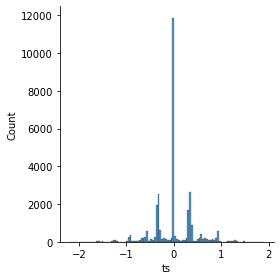

In [874]:
sns.displot(pair_data['ts'], height=4)

## Backtesting

In [970]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'

quote1 = hist_quotes[sym1].drop(columns='day')
quote2 = hist_quotes[sym2].drop(columns='day').copy()

trades1 = hist_trades[sym1].drop(columns='day')
trades2 = hist_trades[sym2].drop(columns='day').copy()

In [971]:
qcols = ['timestamp', 'bid', 'bid_sz','ask', 'ask_sz','volume', 'mid_price']
pair_data = quote1[qcols].merge(quote2[qcols], on=['timestamp'], suffixes=('_'+sym1,'_'+sym2))

In [1373]:
# pair_data['fair_value'] = pair_data['mid_price_PINA_COLADAS']-pair_data['mid_price_COCONUTS']-7000
pair_data['fair_value'] = pair_data['fair_v1_PINA_COLADAS']-pair_data['fair_v1_COCONUTS']*2
pair_data['signal'] = (pair_data['fair_value'] - pair_data['fair_value'].shift(1)).fillna(0)
pair_data['trade'] = (np.abs(pair_data['signal'])>=3)*np.sign(pair_data['signal'])
pair_data.loc[pair_data.trade != 0].shape

(1897, 356)

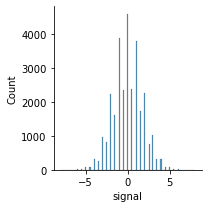

In [1273]:
sns.displot(x='signal',data=pair_data,height=3)

In [1334]:
pnl = [[],[]]
positions = [[0], [0]]
notionals = [[0], [0]]
trades = 0

for i, row in pair_data.iterrows():
    if row['trade'] == 1 or (positions[0][-1] < 0 and row['signal'] <= 0) and positions[0][-1] <= 600:
        trades += 1
        sell_sz = 10
        # sell_sz = min(10, row['ask_sz_COCONUTS']//2, row['bid_sz_PINA_COLADAS'])
        buy_sz = sell_sz*2
        positions[0].append(positions[0][-1]+buy_sz)
        positions[1].append(positions[1][-1]-sell_sz)
        notionals[0] -= buy_sz*row['ask_COCONUTS']
        notionals[1] += sell_sz*row['bid_PINA_COLADAS']
        
    elif row['trade'] == -1 or (positions[0][-1] > 0 and row['signal'] >= 0) and positions[0][-1] >= -600:
        # buy_sz = min(10, row['bid_sz_COCONUTS']//2, row['ask_sz_PINA_COLADAS'])
        trades += 1
        buy_sz = 10
        sell_sz = buy_sz*2
        positions[0].append(positions[0][-1]-sell_sz)
        positions[1].append(positions[1][-1]+buy_sz)
        notionals[0] += sell_sz*row['bid_COCONUTS']
        notionals[1] -= buy_sz*row['ask_PINA_COLADAS']
        
    pnl[0].append(positions[0][-1]*row['mid_price_COCONUTS']-notionals[0])
    pnl[1].append(positions[1][-1]*row['mid_price_PINA_COLADAS']-notionals[1])
pnl = np.squeeze(pnl)

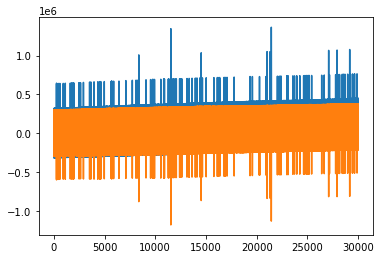

In [1335]:
f, ax = plt.subplots()
pnl_trend = pnl.sum(axis=0)
# ax.plot(pnl_trend)
# print(pnl_trend[-1])
ax.plot(pnl[0], label='pnl_1')
ax.plot(pnl[1], label='pnl_2')

In [ ]:
f, ax = plt.subplots()
ax.plot(np.array(positions).sum(axis=0), label='pnl')

array([     0. ,      0. ,      0. , ..., 130537. , 130556.5, 130517.5])

32878280.5

## Linear Regression

In [534]:
from sklearn.linear_model import LinearRegression, Ridge

In [649]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'

quote1 = hist_quotes[sym1]
quote1_train = quote1.loc[quote1.day < 1].drop(columns='day')
quote1_test = quote1.loc[quote1.day == 1].drop(columns='day')
quote2 = hist_quotes[sym2]
quote2_train = quote2.loc[quote2.day < 1].drop(columns='day')
quote2_test = quote2.loc[quote2.day == 1].drop(columns='day')

In [650]:
pair_data_train = quote1_train.merge(quote2_train, on=['timestamp'], suffixes=('_'+sym1,'_'+sym2))
pair_data_test = quote1_test.merge(quote2_test, on=['timestamp'], suffixes=('_'+sym1,'_'+sym2))

In [652]:
X_col = 'dist_fair_v1_PINA_COLADAS'
y_col = 'dist_fair_v1_COCONUTS'
X = pair_data_train[X_col].values.reshape(-1,1)
y = pair_data_train[y_col].values
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

X_test = pair_data_test[X_col].values.reshape(-1,1)
y_test = pair_data_test[y_col].values
print(reg.score(X_test, y_test))
print(reg.coef_, reg.intercept_)

1.2798922865431273e-05
-0.0003186201346807582
[-0.00380711] 0.012781525338604627


## Kalman Filter

Main concern with using a kalman filter is saving previous state